In [1]:
!git clone https://github.com/baiydaavi/vonenet.git
%cd vonenet/
!git checkout avi

Cloning into 'vonenet'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 116 (delta 59), reused 65 (delta 27), pack-reused 0
Receiving objects: 100% (116/116), 498.05 KiB | 3.11 MiB/s, done.
Resolving deltas: 100% (59/59), done.
/content/vonenet
Branch 'avi' set up to track remote branch 'avi' from 'origin'.
Switched to a new branch 'avi'


In [44]:
import sys
sys.path.append('vonenet/vonenet.py')

In [42]:
import vonenet
import torchvision
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
if not os.path.exists('tiny-imagenet-200/'):
    !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
    !unzip -q tiny-imagenet-200.zip

--2021-08-13 00:09:42--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  10.7MB/s    in 25s     

2021-08-13 00:10:07 (9.60 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [45]:
# Load V1 model
# v1_model = vonenet.get_model(model_arch=None, pretrained=False, noise_mode=None).module
# v1_model = vonenet.get_model(model_arch='resnet50_ns', pretrained=True).module

# v1_model = vonenet.get_model(model_arch=None, pretrained=False, noise_mode=None, image_size=64, visual_degrees=2, sf_max=11.3, stride=2, ksize=25, k_exc=23.5).module
# v1_model = vonenet.get_model(model_arch='resnet18', pretrained=False, noise_mode=None, image_size=64, visual_degrees=2, sf_max=11.3, stride=2, ksize=25, k_exc=23.5).module

from vonenet import VOneNet

v1_model = VOneNet(model_arch='resnet18', noise_mode=None, image_size=64, visual_degrees=2, sf_max=11.3, stride=2, ksize=25, k_exc=23.5)

print(v1_model)

Neuronal distributions gabor parameters
Model:  VOneResnet18


/content/vonenet/vonenet/params.py:59: RuntimeWarning: invalid value encountered in true_divide
  ny_dist_marg = n_joint_dist / n_joint_dist.sum(axis=1, keepdims=True)


Sequential(
  (vone_block): VOneBlock(
    (simple_conv_q0): GFB()
    (simple_conv_q1): GFB()
    (simple): ReLU(inplace=True)
    (complex): Identity()
    (gabors): Identity()
    (noise): ReLU(inplace=True)
    (output): Identity()
  )
  (bottleneck): Conv2d(512, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (model): ResNetBackEnd(
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [27]:
data_path = 'tiny-imagenet-200/train'

bsize = 500
# crop = 256 # 48  256
# px = 224 # 32  224

# torchvision.transforms.Resize(crop),  
# torchvision.transforms.CenterCrop(px),  

normalize = torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                             std=[0.5, 0.5, 0.5])
dataset = torchvision.datasets.ImageFolder(data_path,
    torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        normalize,
    ]))

data_loader = torch.utils.data.DataLoader(dataset, batch_size=bsize, shuffle=True, num_workers=2, pin_memory=True)

dataloader_iterator = iter(data_loader)

In [33]:
X, _ = next(dataloader_iterator)
print(X.shape)

torch.Size([500, 3, 64, 64])


In [34]:
activations = v1_model(X)
print(activations.shape)
print(torch.mean(activations.reshape(-1)))

torch.Size([500, 512, 32, 32])
tensor(1.0076)


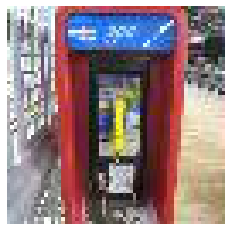

In [35]:
im_ind=6

input_im = np.moveaxis(X[im_ind].numpy(),0,-1)
input_im = input_im/2 +0.5
    
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(4,4)
im_h=ax.imshow(input_im)
im_h.set_clim([0, 1])
ax.set_axis_off()
plt.show()

In [38]:
sorted_activations = np.argsort(np.std(activations[im_ind].numpy().reshape((512, -1)), axis=1))

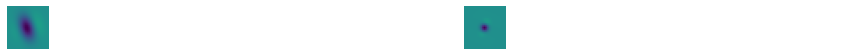

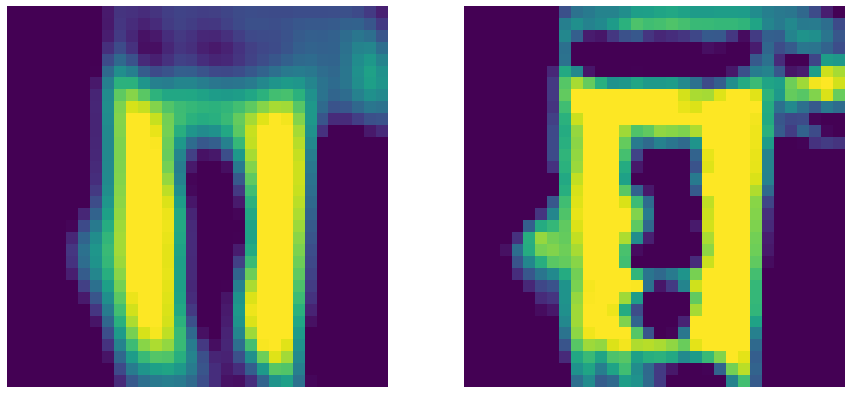

In [40]:
v1_ind= sorted_activations[-2:]#np.array([233, 204])

fig, ax = plt.subplots(nrows=1, ncols=len(v1_ind))
fig.set_size_inches(15,5)
for v1_i, v1_ind_ in enumerate(v1_ind):
    v1_k = v1_model.simple_conv_q0.weight[v1_ind_,:,:,:].numpy().mean(axis=0)
    v1_k = v1_k / np.amax(np.abs(v1_k))/2+0.5
    im_h=ax[v1_i].imshow(v1_k) #, cmap='gray'
    ax[v1_i].set_xlim([0, px])
    im_h.set_clim([0, 1])
    ax[v1_i].set_axis_off()
plt.show()


fig, ax = plt.subplots(nrows=1, ncols=len(v1_ind))
fig.set_size_inches(15,15)
max_activations = np.amax(activations[im_ind].numpy())/np.sqrt(2)
for v1_i, v1_ind_ in enumerate(v1_ind):
    v1_im = activations[im_ind,v1_ind_].numpy()
    v1_im = v1_im / max_activations
    im_h=ax[v1_i].imshow(v1_im) #, cmap='gray'
    im_h.set_clim([0, 1])
    ax[v1_i].set_axis_off()
plt.show()





In [18]:
v1_im

array([[0.04750493, 0.05216173, 0.04348995, ..., 0.39543727, 0.3553459 ,
        0.2537369 ],
       [0.06380782, 0.0794601 , 0.07687839, ..., 0.46284512, 0.44036132,
        0.33621326],
       [0.07523064, 0.10920075, 0.12205703, ..., 0.484446  , 0.4891561 ,
        0.39694527],
       ...,
       [0.        , 0.        , 0.        , ..., 1.0598258 , 1.0996464 ,
        0.9301624 ],
       [0.        , 0.        , 0.        , ..., 0.90005857, 0.9650026 ,
        0.83910125],
       [0.        , 0.        , 0.        , ..., 0.7004717 , 0.7782359 ,
        0.699704  ]], dtype=float32)

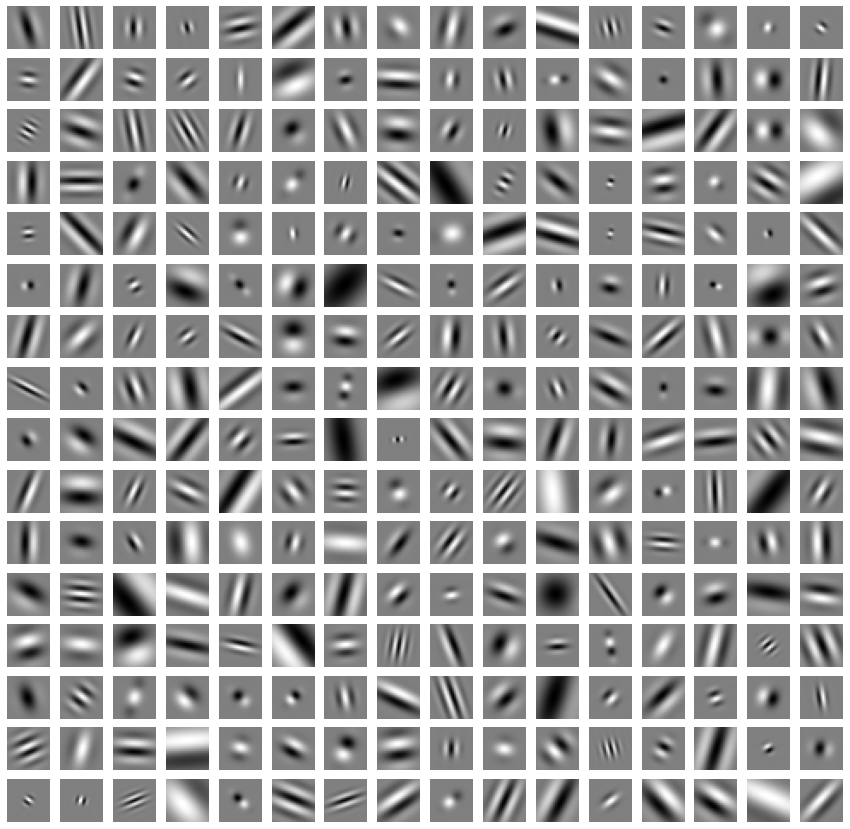

In [19]:
num_channels=256
max_columns = 16

fig, ax = plt.subplots(nrows=num_channels//max_columns, ncols=max_columns)

fig.set_size_inches(15,15)
for i in range(num_channels):
    v1_k = v1_model.simple_conv_q0.weight[i,:,:,:].numpy().mean(axis=0)
    v1_k = v1_k / np.amax(np.abs(v1_k))/2+0.5
    im_h=ax[i//max_columns, np.mod(i,max_columns)].imshow(v1_k, cmap='gray')
#     ax[i//num_channels, np.mod(i,num_channels)].set_xlim([0, 223])
    im_h.set_clim([0, 1])
    ax[i//max_columns, np.mod(i,max_columns)].set_axis_off()
plt.show()

In [8]:
# Nyquist
import numpy as np 

visual_degrees = 2
image_size = 64

nyquist_f = 1/(visual_degrees/image_size)/2 / np.sqrt(2)

print(nyquist_f)

11.31370849898476
